## Курсовая работа Вилюнайте Дайны, группа ПИ20-1в
### Тема работы "Создание алгоритма прогнозирования прибыли с использованием нейронных сетей"

In [3]:
# импорт библиотек
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import random
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO

#свой модуль
from utils import collate_fn, rescale_boxes, train_one_epoch, evaluate


Определяем класс Датасета. Класс наследуется от CocoDetection, аннотации к изображениям в формате COCO .json

In [4]:
class ApplesDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transform=None):
        super(ApplesDataset, self).__init__(img_folder, ann_file)
        #Загрузка файла с аннотациями в формате COCO
        self.coco = COCO(ann_file)
        self.categories = self.coco.loadCats(self.coco.getCatIds()) #у нас одна категория - apple
        self.image_ids = self.coco.getImgIds()
        self.transform = transform

    def __getitem__(self, index):
        img, ann = super(ApplesDataset, self).__getitem__(index)

        #Получаем изображение
        img_id = self.image_ids[index]
        img_data = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_data['file_name'])
        img = Image.open(img_path).convert("RGB")
        
        #Загружаем аннотации для каждого элемента
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        #Для ускорения обучения дальнейшем будут уменьшены размеры изображений, 
        # поэтому нам также необходимо сменить координаты контейнеров
        anns = rescale_boxes(anns, (4032, 2528), (1276, 800))

        #формирование списка размеченных объектов
        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            # Преобразование формата bboxes из (x, y, w, h) в (x1, y1, x2, y2)
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            boxes.append(bbox)
            labels.append(ann['category_id'])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #допущение, что объекты нескученны
        iscrowd = torch.zeros((len(anns),), dtype=torch.int64)

        #формирование целевой переменной
        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

        #преобразования изображения
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

Предварительная обработка изображений включает преобразование к тензору и изменение разрешения. Так как в дальнейшем будет использоваться модель ResNet50, нет необходимости делать на этом этапе нормализацию - она будет автоматически применена при обучении. Также можель ResNet предполагает размер изображений 800х800, и при обучении будет произведено изменение размера. Чтоюы сделать это более явно, Resize добавлен на этом этапе.

In [5]:
img_transforms = transforms.Compose([transforms.ToTensor(), 
                  torchvision.transforms.Resize((800, 1276), antialias=True)])

Загрузка тренировочного и тестового датасетов. Также определяем data loader-ы для этих датасетов. Функция collate_fn

In [6]:
# Путь к папкам с данными
train_img_folder = 'data\\apples_train\\'
train_ann_file = 'data\\apples_train\\apples_coco.json'

test_img_folder = 'data\\apples_test\\'
test_ann_file = 'data\\apples_test\\apples_coco.json'

#Создаем датасеты
train_dataset = ApplesDataset(img_folder=train_img_folder,
                           ann_file=train_ann_file,
                           transform=img_transforms)

test_dataset = ApplesDataset(img_folder=test_img_folder,
                           ann_file=test_ann_file,
                           transform=img_transforms)

#Создаем загрузчики данных
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Проверим, что датасет правильно загрузился - выведем одно случайное изображение, на которое добавим bounding boxes - границы объектов

Количество яблок на фото: 3


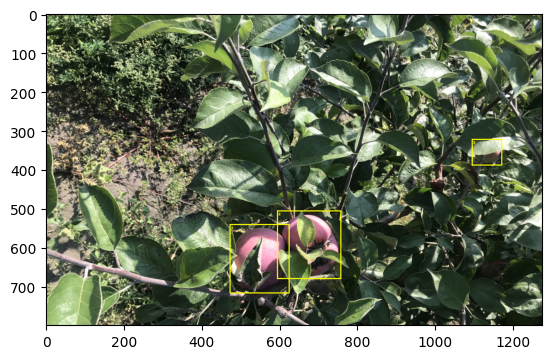

In [9]:
# Получаем случайное изображение
index = random.randint(0, len(train_dataset) - 1)
image, target = train_dataset[index]

# Добавляем bounding boxes
image = image.mul(255).to(torch.uint8) #Для добавления bboxes преобразуем формат тензора
labels = [str(i[0]+1) for i in enumerate(target['labels'])]
image= draw_bounding_boxes(image, target['boxes'], colors='yellow', width=3, labels=labels)

print(f'Количество яблок на фото: {len(target["labels"])}')

# Отрисовка изображения
plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()
# Второй способ вывода
# image = torchvision.transforms.ToPILImage()(image)
# image.show()

In [10]:
train_dataset[index]

(tensor([[[0.5734, 0.5124, 0.4380,  ..., 0.2899, 0.2991, 0.2823],
          [0.6297, 0.7133, 0.6223,  ..., 0.2864, 0.2896, 0.2910],
          [0.4256, 0.7048, 0.7292,  ..., 0.2781, 0.2865, 0.2949],
          ...,
          [0.8192, 0.9356, 0.8133,  ..., 0.0462, 0.0478, 0.0480],
          [0.7347, 0.9203, 0.8093,  ..., 0.0493, 0.0432, 0.0428],
          [0.6359, 0.8976, 0.8104,  ..., 0.0513, 0.0480, 0.0405]],
 
         [[0.6556, 0.5795, 0.4943,  ..., 0.3331, 0.3423, 0.3255],
          [0.6954, 0.7858, 0.7017,  ..., 0.3317, 0.3344, 0.3358],
          [0.4748, 0.7822, 0.8276,  ..., 0.3288, 0.3372, 0.3457],
          ...,
          [0.8353, 0.9670, 0.8672,  ..., 0.0776, 0.0792, 0.0793],
          [0.7500, 0.9533, 0.8637,  ..., 0.0807, 0.0745, 0.0741],
          [0.6514, 0.9311, 0.8648,  ..., 0.0827, 0.0793, 0.0719]],
 
         [[0.4763, 0.3986, 0.3150,  ..., 0.2063, 0.2173, 0.2005],
          [0.5224, 0.6028, 0.5100,  ..., 0.1928, 0.1985, 0.1998],
          [0.3148, 0.6027, 0.6305,  ...,

В качестве модели была выбрана предобученная модель ResNet50. При инициализации можель принимает на вход количество классов в наборе данных + дополнительный класс для фона изображения.

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Кол-во классов + 1 (фон)
num_classes = 2

#model = get_instance_segmentation_model(num_classes)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)

# В качестве оптимизатора выбран метод стохастического градиентного спуска
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# Скорость обучения снижаем каждые 3 эпохи в 10 раз 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

c:\Users\daina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:

num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq = 10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, test_loader, device=device)